# Accuracy and Time

In [ ]:
from glob import glob
import json
import pandas as pd

files = glob('./output/experiments_layer_development_investigation/*.json')

all_dicts = []

for file in files:
    with open(file, "r") as f:
        data = json.load(f)
        all_dicts.append(data)

df = pd.DataFrame(all_dicts)

df["average_training_time_per_epoch"] = df["time"] / df["epochs"]

df.sort_values("average_training_time_per_epoch")

,epochs,training_accuracy,test_accuracy,time,num_hidden_layer,num_hidden_neurons,sparsity,beta,threshold,average_training_time
8,25,0.874571,57.906360,11138.702326,2,3000,0.0,0.80,3.0,445.548093
10,20,0.961869,55.256184,8956.519206,2,3000,0.0,0.50,1.0,447.825960
6,18,0.970329,56.227915,8095.335637,2,3000,0.0,0.50,0.7,449.740869
5,13,0.976704,71.687279,6073.187051,2,3000,0.0,0.80,0.7,467.168235
9,8,0.309465,22.482332,3850.559719,2,3000,0.0,0.50,3.0,481.319965
0,14,0.973639,74.204947,6889.320075,2,3000,0.0,NaN,NaN,492.094291
7,10,0.960152,70.053004,5234.016630,2,3000,0.0,0.99,1.0,523.401663
1,16,0.980383,73.056537,8881.551641,2,3000,0.2,0.99,1.0,555.096978
4,16,0.972903,70.583039,9005.488404,2,3000,0.0,0.80,1.0,562.843025
2,6,0.455248,39.796820,5581.846544,2,3000,0.0,0.99,3.0,930.307757


# Layer Development

In [2]:
from layer_development_investigation_experiment import best_grid_search_model, best_grid_search_model_80_percent_of_connections, best_grid_search_model_50_percent_of_connections, best_grid_search_model_20_percent_of_connections, best_grid_search_model_5_percent_of_connections
import torch
from constants import TIME_STEPS
from util.utils import get_device
from torch.utils.data import DataLoader
from tonic import datasets, transforms

/home/mark/anaconda3/envs/whk-snn/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ImportError: cannot import name 'best_grid_search_model' from 'layer_development_investigation_experiment' (/home/mark/Dokumente/whk-snn/whk-snn/heidelberg_implementation/layer_development_investigation_experiment.py)

In [ ]:
best_grid_search_model.load_state_dict(torch.load('./models/experiment_layer_development_investigation/best_grid_search.pth'))
best_grid_search_model_80_percent_of_connections.load_state_dict(torch.load('./models/experiment_layer_development_investigation/best_grid_search_80_percent_connections.pth'))
best_grid_search_model_50_percent_of_connections.load_state_dict(torch.load('./models/experiment_layer_development_investigation/best_grid_search_50_percent_connections.pth'))
best_grid_search_model_20_percent_of_connections.load_state_dict(torch.load('./models/experiment_layer_development_investigation/best_grid_search_20_percent_connections.pth'))
best_grid_search_model_5_percent_of_connections.load_state_dict(torch.load('./models/experiment_layer_development_investigation/best_grid_search_5_percent_connections.pth'))

<All keys matched successfully>

In [ ]:
selection_index = 2
device = get_device()

frame_transform = transforms.ToFrame(
    sensor_size=datasets.SHD.sensor_size,  
    n_time_bins=TIME_STEPS
)

test_data = datasets.SHD("./data", transform=frame_transform, train=False)

test_data_loader = DataLoader(test_data, shuffle=False, batch_size=32)

data, target = list(test_data_loader)[0]
data = data.to_dense().to(torch.float32).squeeze().permute(1, 0, 2).to(device)

x_selected = data[:, selection_index, :]
y_selected = target[selection_index]


In [ ]:
def get_spk_matrices(data, model, selection_index):
    spk_recs, _ = model(data)

    output_spk_rec = spk_recs[-1][:, selection_index, :]
    hidden_spk_rec = [hidden_spk_rec[:, selection_index, :].detach() for hidden_spk_rec in spk_recs[:-1]]

    return [x_selected, *hidden_spk_rec, output_spk_rec.detach()]

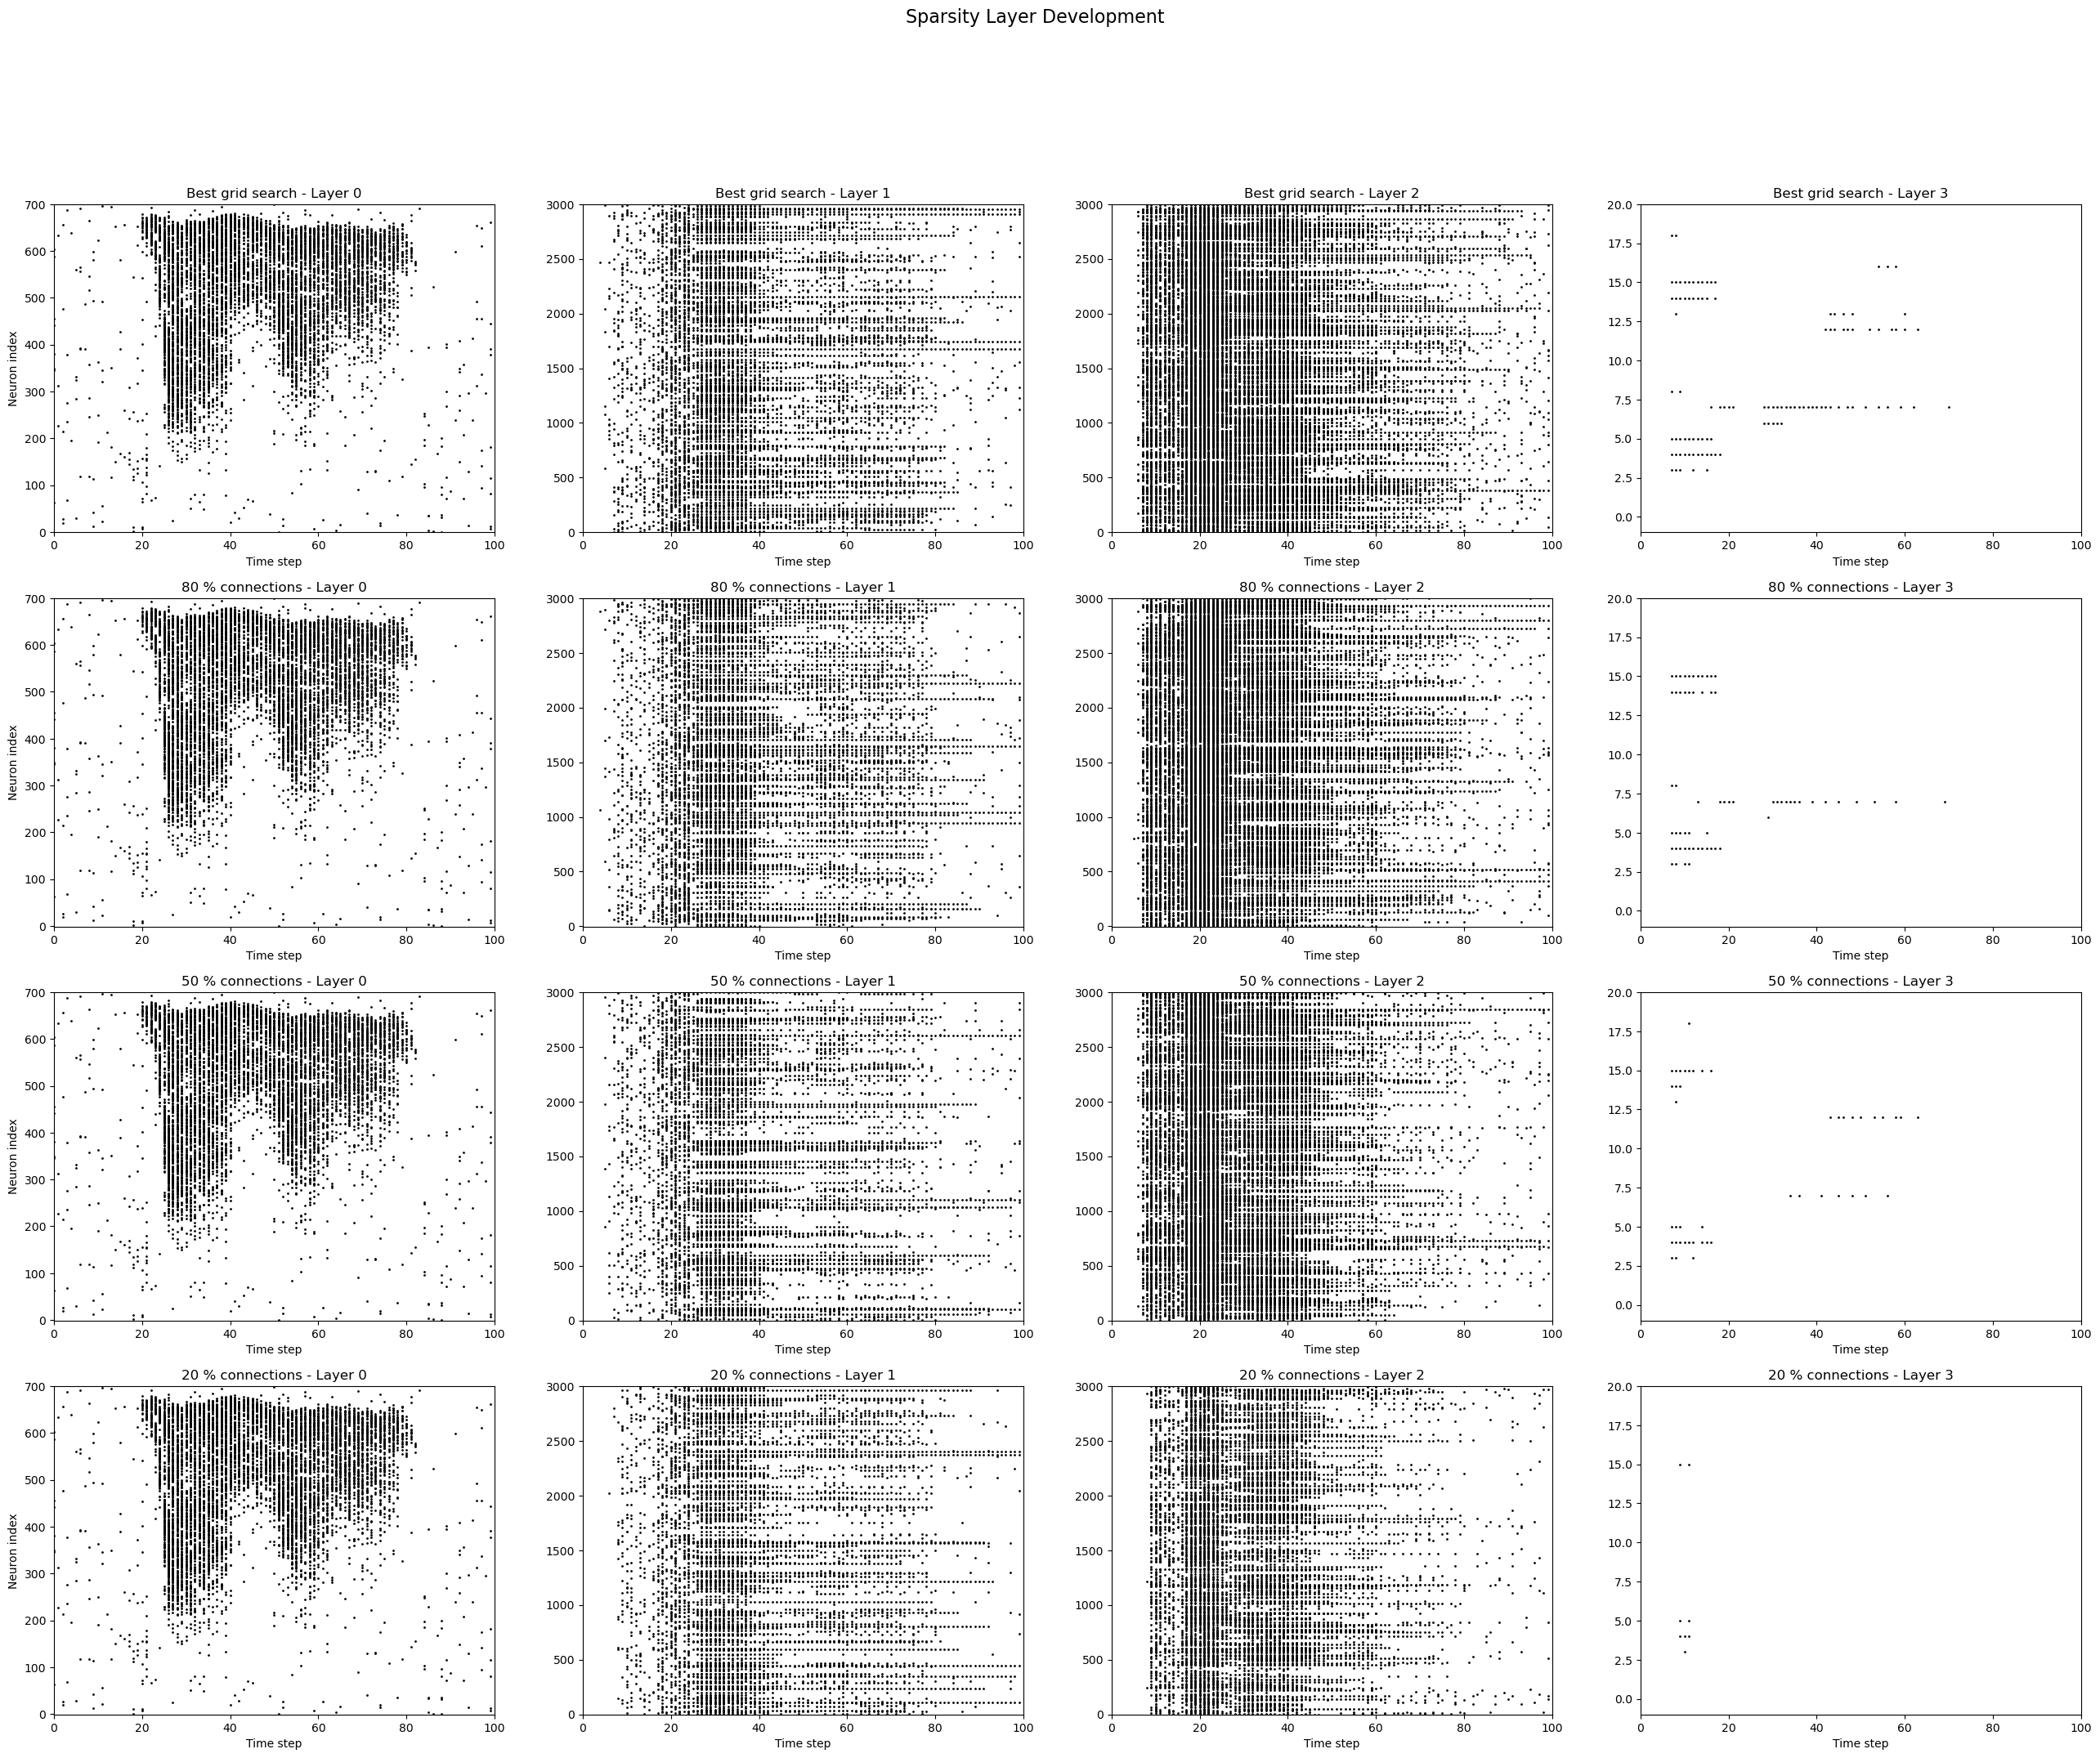

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

spike_matrices_best_grid_search = get_spk_matrices(data, best_grid_search_model, selection_index)
spike_matrices_best_grid_search_80_percent = get_spk_matrices(data, best_grid_search_model_80_percent_of_connections, selection_index)
spike_matrices_best_grid_search_50_percent = get_spk_matrices(data, best_grid_search_model_50_percent_of_connections, selection_index)
spike_matrices_best_grid_search_20_percent = get_spk_matrices(data, best_grid_search_model_20_percent_of_connections, selection_index)
spike_matrices_best_grid_search_5_percent = get_spk_matrices(data, best_grid_search_model_5_percent_of_connections, selection_index)

fig, axes = plt.subplots(4, len(spike_matrices_best_grid_search), figsize=(40, 32))

fig.suptitle("Sparsity Layer Development", fontsize=16)

for index in range(len(spike_matrices_best_grid_search)):
    spike_matrix_np = spike_matrices_best_grid_search[index].numpy()
    times, neurons = np.where(spike_matrix_np == 1)
    ax = axes[0, index]
    ax.scatter(times, neurons, s=1, color='black')
    ax.set_title(f"Best grid search - Layer {index}")
    ax.set_xlabel("Time step")
    ax.set_ylim(-1, spike_matrix_np.shape[1])
    ax.set_xlim(0, 100)
    if index == 0:
        ax.set_ylabel("Neuron index")

    spike_matrix_np = spike_matrices_best_grid_search_80_percent[index].numpy()
    times, neurons = np.where(spike_matrix_np == 1)
    ax = axes[1, index]
    ax.scatter(times, neurons, s=1, color='black')
    ax.set_title(f"80 % connections - Layer {index}")
    ax.set_xlabel("Time step")
    ax.set_ylim(-1, spike_matrix_np.shape[1])
    ax.set_xlim(0, 100)
    if index == 0:
        ax.set_ylabel("Neuron index")

    spike_matrix_np = spike_matrices_best_grid_search_50_percent[index].numpy()
    times, neurons = np.where(spike_matrix_np == 1)
    ax = axes[2, index]
    ax.scatter(times, neurons, s=1, color='black')
    ax.set_title(f"50 % connections - Layer {index}")
    ax.set_xlabel("Time step")
    ax.set_ylim(-1, spike_matrix_np.shape[1])
    ax.set_xlim(0, 100)
    if index == 0:
        ax.set_ylabel("Neuron index")

    spike_matrix_np = spike_matrices_best_grid_search_20_percent[index].numpy()
    times, neurons = np.where(spike_matrix_np == 1)
    ax = axes[3, index]
    ax.scatter(times, neurons, s=1, color='black')
    ax.set_title(f"20 % connections - Layer {index}")
    ax.set_xlabel("Time step")
    ax.set_ylim(-1, spike_matrix_np.shape[1])
    ax.set_xlim(0, 100)

    if index == 0:
        ax.set_ylabel("Neuron index")

    spike_matrix_np = spike_matrices_best_grid_search_5_percent[index].numpy()
    times, neurons = np.where(spike_matrix_np == 1)
    ax = axes[3, index]
    ax.scatter(times, neurons, s=1, color='black')
    ax.set_title(f"5 % connections - Layer {index}")
    ax.set_xlabel("Time step")
    ax.set_ylim(-1, spike_matrix_np.shape[1])
    ax.set_xlim(0, 100)

    if index == 0:
        ax.set_ylabel("Neuron index")